In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog, local_binary_pattern, canny
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn import svm, metrics

# TODO
# t-SNE
# Hyper-parameter tuning
# It was observed from the confusion matrix that all classifiers performed worse in these scenarios:
# 1. Predicting label 2 as 1, and predicting label 1 as 2

In [2]:
df = pd.read_csv('./dataset/label.csv')
df.head()

,file_name,label
0,IMAGE_0000.jpg,meningioma_tumor
1,IMAGE_0001.jpg,no_tumor
2,IMAGE_0002.jpg,meningioma_tumor
3,IMAGE_0003.jpg,glioma_tumor
4,IMAGE_0004.jpg,meningioma_tumor


In [36]:
df['label'].value_counts()

glioma_tumor        860
meningioma_tumor    855
pituitary_tumor     831
no_tumor            454
Name: label, dtype: int64

In [4]:
def create_classes(df):
    '''
    Inputs
        df: Label data.
        
    Return
        classes: List of labels - 0 if no_tumor, 1 if glioma_tumor, 2 if meningioma_tumor, 3 if pituitary_tumor
    '''
    
    classes = []
    for label in df['label']:
        if 'no_tumor' in label:
            classes.append(0)
        elif 'glioma_tumor' in label:
            classes.append(1)
        elif 'meningioma_tumor' in label:
            classes.append(2)
        elif 'pituitary_tumor' in label:
            classes.append(3)
    return classes

In [5]:
def extract_hog(data_path, df):
    '''
    Inputs
        data_path: Directory path to images in dataset;
        df: Label data.
        
    Return
       hog_features: A list of HOG features for each image
    '''
    hog_features = []
    for filename in df['file_name']:
        # use imread to load image from specified file name in grayscale
        im = imread(os.path.join(data_path, filename), as_gray = True)
        # use resize the image to a 128 by 64 pixel image
        resized_im = resize(im, (128, 64))
        # Extract Histogram of Oriented Gradients (HOG) for the image
        fd = hog(resized_im, orientations = 9, pixels_per_cell = (8, 8),
                            cells_per_block = (2, 2), visualize = False, block_norm='L2-Hys')
        hog_features.append(fd)
    return hog_features

In [6]:
def extract_lbp(data_path, df, numPoints, radius):
    '''
    Inputs
        data_path: Directory path to images in dataset;
        df: Label data.
        
    Return
       lbp_features: A list of Local Binary Pattern (LBP) features for each image
    '''
    lbp_features = []
    for filename in df['file_name']:
        # use imread to load image from specified file name in grayscale
        im = imread(os.path.join(data_path, filename), as_gray = True)
        # use resize the image to a 128 by 64 pixel image
        resized_im = resize(im, (128, 64))
        
        # Extract Local Binary Pattern (LBP) for the image
        lbp = local_binary_pattern(resized_im, numPoints, radius, method="uniform")
        # Create bins for histogram
        n_bins = int(lbp.max() + 1)
        # Create histogram for image
        (hist, _) = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
        
        # # normalize the histogram
        # hist = hist.astype("float")
        # hist /= (hist.sum() + eps)
        
        lbp_features.append(hist)
    return lbp_features

In [7]:
def extract_canny(data_path, df, sigma):
    '''
    Inputs
        data_path: Directory path to images in dataset;
        df: Label data.
        
    Return
       canny_features: A list of Local Binary Pattern (LBP) features for each image
    '''
    canny_features = []
    for filename in df['file_name']:
        # use imread to load image from specified file name in grayscale
        im = imread(os.path.join(data_path, filename), as_gray = True)
        # use resize the image to a 128 by 64 pixel image
        resized_im = resize(im, (128, 64))
        
        # Compute the Canny filter for the image
        filtered_im = canny(resized_im, sigma=sigma)
        filtered_im = filtered_im.ravel()
        
        canny_features.append(filtered_im)
    return canny_features

In [8]:
def PCAPredict(X_train, X_test, k):
    '''
    Inputs
        X_train: Training dataset;
        X_test: Testing dataset;
        k: Number of components to use.
        
    Return
        X_train_PCA: Training dataset after applying PCA to reduce its dimensions;
        X_test_PCA: Test dataset after applying PCA to reduce its dimensions.
    '''

    # the built-in function for PCA
    pca = PCA(k)
    
    # the built-in function to standardize features by removing the mean and scaling to unit variance
    scaler = StandardScaler()
    
    # fit the algorithm with dataset
    
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    pca.fit(X_train_scaled)
    X_train_PCA = pca.transform(X_train_scaled)
    X_test_PCA = pca.transform(X_test_scaled)
    
    # pca.fit(X_train)
    # X_train_PCA = pca.transform(X_train)
    # X_test_PCA = pca.transform(X_test)
    
    return X_train_PCA, X_test_PCA

In [9]:
if os.path.exists('./dataset/label_taskB_hog.csv'):
    print('The csv file for Task B with HOG features data already exists')
else:
    data_path = './dataset/image'
    classes = create_classes(df)
    hog_features = extract_hog(data_path, df)
    
    label_taskB = pd.DataFrame(data = hog_features)
    label_taskB['num_label'] = classes
    label_taskB.to_csv("./dataset/label_taskB_hog.csv")

The csv file for Task B with HOG features data already exists


In [10]:
if os.path.exists('./dataset/label_taskB_lbp.csv'):
    print('The csv file for Task B with lbp features data already exists')
else:
    data_path = './dataset/image'
    classes = create_classes(df)
    lbp_features = extract_lbp(data_path, df, 24, 3)
    
    label_taskB = pd.DataFrame(data = lbp_features)
    label_taskB['num_label'] = classes
    label_taskB.to_csv("./dataset/label_taskB_lbp.csv")

The csv file for Task B with lbp features data already exists


In [11]:
if os.path.exists('./dataset/label_taskB_canny.csv'):
    print('The csv file for Task B image data filtered with Canny filter already exists')
else:
    data_path = './dataset/image'
    classes = create_classes(df)
    canny_features = extract_canny(data_path, df, 3)
    
    label_taskB = pd.DataFrame(data = canny_features)
    label_taskB['num_label'] = classes
    label_taskB.to_csv("./dataset/label_taskB_canny.csv")

The csv file for Task B image data filtered with Canny filter already exists


In [12]:
feature = 'hog'
usingPCA = True

if feature == 'hog':
    # Doing classification with image HOG features
    label_taskB = pd.read_csv("./dataset/label_taskB_hog.csv")
elif feature == 'lbp':
    # Doing classification with image LBP features
    label_taskB = pd.read_csv("./dataset/label_taskB_lbp.csv")
    usingPCA = True
elif feature == 'canny':
    # Doing classification with Canny filtered image data
    label_taskB = pd.read_csv("./dataset/label_taskB_canny.csv")
    usingPCA = True
    
X = label_taskB.drop('num_label',axis=1) # All other features
Y = label_taskB['num_label'] # numerical label/classes

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 3) 
#test_size= should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split
#everytime you run it without specifying random_state, you will get a different result, this is expected behavior
#print (len(X_test), len(y_test))

print('train set: {}  | test set: {}'.format(round(((len(y_train)*1.0)/len(X)),3),
                                                       round((len(y_test)*1.0)/len(X),3)))
# Doing image pre-processing with PCA
if usingPCA == True:
    k = 0.95
    X_train, X_test = PCAPredict(X_train, X_test, k)

train set: 0.7  | test set: 0.3


KNN classifier score: 0.8588888888888889


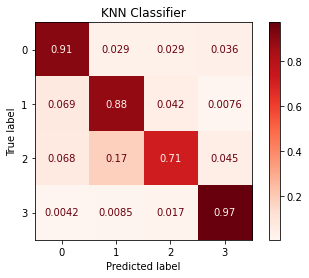

In [32]:
def KNNClassifier(X_train, y_train, X_test, k):
    '''
    Inputs
        X_train: Training dataset;
        y_train: Training labels;
        X_test: Testing dataset;
        k: Number of nearest neighbours to use.
        
    Return
        Y_pred: Predicted labels from X_test using K-Nearest Neighbour.
    '''

    #Create KNN object with a K coefficient
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train) # Fit KNN model

    Y_pred = neigh.predict(X_test)
    
    disp = metrics.ConfusionMatrixDisplay.from_estimator(
        neigh,
        X_test,
        y_test,
        cmap=plt.cm.Reds,
        normalize='true'
    )
    disp.ax_.set_title('KNN Classifier')
    
    return Y_pred, disp

# clf = svm.SVC()
# clf.fit(X_train, y_train)
# Y_pred = clf.predict(X_test)
# throws error: setting an array element with a sequence
# when getting X from dataframe, the resulting array is dtype object,
# but when getting X directly from hog_features, resulting array is dtype float??

Y_pred_KNN, disp_KNN = KNNClassifier(X_train, y_train, X_test, 2)
score_KNN = metrics.accuracy_score(y_test, Y_pred_KNN)
print('KNN classifier score:', score_KNN)

Random Forest classifier score: 0.7788888888888889


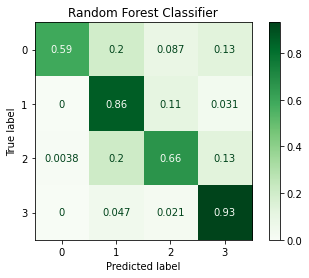

In [33]:
def RFClassifier(X_train, y_train, X_test, k):
    '''
    Inputs
        X_train: Training dataset;
        y_train: Training labels;
        X_test: Testing dataset;
        k: Number of trees in the forest.
        
    Return
        Y_pred: Predicted labels from X_test using Random Forests.
    '''
    
    clf=RandomForestClassifier(n_estimators=k)

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    # prediction on test set
    Y_pred=clf.predict(X_test)

    disp = metrics.ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        cmap=plt.cm.Greens,
        normalize='true'
    )
    disp.ax_.set_title('Random Forest Classifier')
    
    return Y_pred, disp

Y_pred_RandomForest, disp_RF = RFClassifier(X_train, y_train, X_test, 150)
score_RandomForest = metrics.accuracy_score(y_test, Y_pred_RandomForest)
print('Random Forest classifier score:', score_RandomForest)

SVM classifier score: 0.8511111111111112


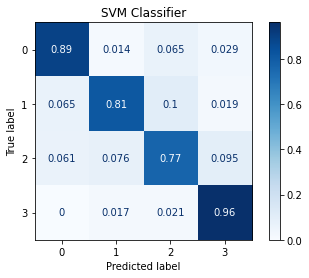

In [29]:
def SVMClassifier(X_train, y_train, X_test):
    '''
    Inputs
        X_train: Training dataset;
        y_train: Training labels;
        X_test: Testing dataset.
        
    Return
        Y_pred: Predicted labels from X_test using SVM.
    '''

    #Create SCV object with a K coefficient
    clf = svm.SVC(kernel='rbf', degree=3,  probability=True)
    clf.fit(X_train, y_train)
    Y_pred = clf.predict(X_test)

    # classes: List of labels - 0 if no_tumor, 1 if glioma_tumor, 2 if meningioma_tumor, 3 if pituitary_tumor
    disp = metrics.ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize='true'
    )
    disp.ax_.set_title('SVM Classifier')
    
    return Y_pred, disp

Y_pred_SVM, disp_SVM = SVMClassifier(X_train, y_train, X_test)
score_SVM = metrics.accuracy_score(y_test, Y_pred_SVM)
print('SVM classifier score:', score_SVM)

Voting classifier score: 0.8588888888888889


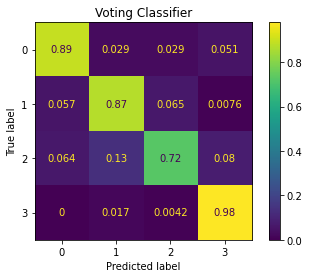

In [34]:
def voting(X_train, y_train, X_test, n_neighbours, n_trees):
    clf1 = svm.SVC(kernel='rbf', degree=3,  probability=True)
    # clf2 = LogisticRegressionCV(cv=5, multi_class='multinomial', max_iter = 400, random_state=0)
    clf2 = RandomForestClassifier(n_estimators=n_trees)
    clf3 = KNeighborsClassifier(n_neighbors=n_neighbours)

    eclf1 = VotingClassifier(estimators=[
        ('svc', clf1), ('rf', clf2), ('knn', clf3)], voting='hard')
    eclf1.fit(X_train, y_train)

    Y_pred = eclf1.predict(X_test)

    disp = metrics.ConfusionMatrixDisplay.from_estimator(
        eclf1,
        X_test,
        y_test,
        cmap='viridis',
        normalize='true'
    )
    disp.ax_.set_title('Voting Classifier')

    return Y_pred, disp

Y_pred_voting, disp_voting = voting(X_train, y_train, X_test, 2, 150)
score_voting = metrics.accuracy_score(y_test, Y_pred_voting)
print('Voting classifier score:', score_voting)

In [16]:
def baggingClassifierML(X_train, y_train, X_test,k):

    # Bagging takes Decision Tree as its base-estimator model by default.
    bagmodel=BaggingClassifier(n_estimators=k,max_samples=0.5, max_features=4,random_state=1)
    bagmodel.fit(X_train, y_train) # Fit KNN model


    Y_pred = bagmodel.predict(X_test)
    #print (Y_pred)
    
    return Y_pred

In [17]:
def boostingClassifierML(X_train, y_train, X_test,k):
    # AdaBoost takes Decision Tree as its base-estimator model by default.
    boostmodel=AdaBoostClassifier(n_estimators=k)
    boostmodel.fit(X_train, y_train,sample_weight=None) # Fit KNN model


    Y_pred = boostmodel.predict(X_test)
    #print (Y_pred)
    return Y_pred

ValueError: too many values to unpack (expected 2)

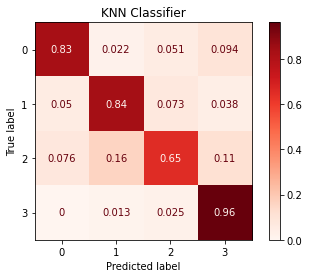

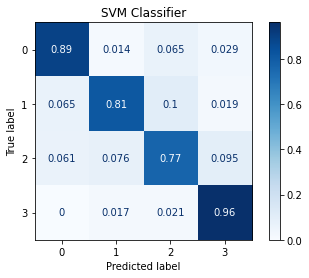

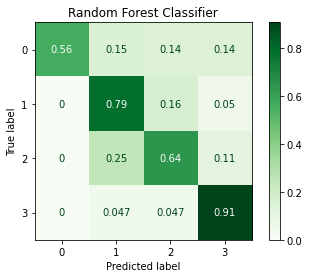

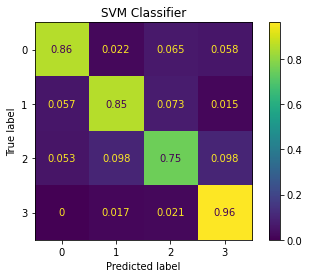

In [26]:
# Y_pred_bagging = baggingClassifierML(X_train, y_train, X_test, 10)
# score_bagging = metrics.accuracy_score(y_test, Y_pred_bagging)

# Y_pred_boosting=boostingClassifierML(X_train, y_train, X_test, 10)
# score_boosting=metrics.accuracy_score(y_test, Y_pred_boosting)

# print('Bagging classifier score:', score_bagging)
# print('ADA Boosting classifier score:', score_boosting)